# Transfer Learning with TensorFlow part 1: Feature Extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem.

There are two main benefits:

1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data.

## Downloading and becoming one with the data

In [1]:
# How many images in each folder?

import os

# walk though 10 percent data directory and list number of files

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 2 directories and 0 images in '10_food_classes_10_percent\10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent\10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '10_food_classes_10_percent\10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent\10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent\10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent\10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent\10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent\10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 

## Creating data loeader(preparing the data)

we'll use the "ImageDataGenerator" class to load in our images in batches.

In [2]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# generalmente las letras mayusculas indican algun tipo de hiperparametro
IMAGE_SHAPE =(224, 224) 

BATCH_SIZE = 32

train_dir= "10_food_classes_10_percent/10_food_classes_10_percent/train/"

test_dir="10_food_classes_10_percent/10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)

test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")

train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")
print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")





Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks(hings to run whilst our model trains)
Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:
* Tracking experiment with the TensorBoard callback

* Model checkpoint with the ModelCheckpoint callback

* Stopping model from training(before it trains too long and overfits) with the EarlyStopping callback

In [3]:
# Create a TensorBoard callback( functionzed because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    
    print(f"Saving TensorBoard log files to: {log_dir}")
    
    return tensorboard_callback
    


**Note:** You can customize the directory where your TensorBoard logs(model training metrics) get saved to whatever you like.

The log_dir parameter we've created above is only one option.

## Creating models using TensorFlow Hub

In the past we've used TensorFlow to create our own models layer by layer from scratch.


Now we're goint to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub.

We can access pretrained model on : https://tfhub.dev/


Browsing the TensorFlow Hub Page and sorting for image classification, we  found the following feature vector model  link: https://tfhub.dev/tensorflow/efficientnet/lite0/feature-vector/2

In [17]:
# let's compare the following two models
resnet_url ="https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

efficientnet_url ="https://tfhub.dev/tensorflow/efficientnet/lite0/feature-vector/2"



In [5]:
# Import dependencies

import tensorflow as tf

import tensorflow_hub as hub

from tensorflow.keras import layers

In [6]:
# forma curriosa de agregar una dimension
IMAGE_SHAPE + (3,)

(224, 224, 3)

In [7]:
# Let's make a create_model() function to create a model from a URL

def create_model(model_url, num_classes=10):
    """
     Takes a TensorFlow Hub URL and create a Keras Sequential model with it.
  
      
    Args:
      model_url(str): A TensorFlow Hub feature extraction URL.
      
      number_classes(int): Number of output neurons in the ouput layer,
          should be equal to number to target classes, default 10.
          
    Returns:
        An uncompiled Keras Sequential model with model_url as feature extractor
        leyer and Dense output layer with num_classes output neurons.
    """
    
    

    # Download the pretrained model and save it as a Keras layer
    feature_extractor_layer = hub.KerasLayer(model_url,
                                            trainable=False,# freeze the already learned patterns
                                            name = "feature_extraction_layer",
                                            input_shape=IMAGE_SHAPE + (3,))

    # Create Create our own model

    model = tf.keras.Sequential([
         feature_extractor_layer,
         layers.Dense(num_classes, activation="softmax", name="output_layer")
     ])

    return model
    

### Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [9]:
# Create Resnet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [10]:
train_data_10_percent.num_classes

10

In [11]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [12]:
# Compile our resnet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [13]:
# Let's fit our ResNet model to the data(10 percent of 10 classes)
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="Tensorflow_hub",
                                                                        experiment_name="restnet50v2")])

Saving TensorBoard log files to: Tensorflow_hub/restnet50v2/210514-042426
Epoch 1/5
24/24 [==============================] - 320s 14s/step - loss: 2.3281 - accuracy: 0.2305 - val_loss: 1.2700 - val_accuracy: 0.5996
Epoch 2/5
24/24 [==============================] - 303s 13s/step - loss: 0.9988 - accuracy: 0.6911 - val_loss: 0.8954 - val_accuracy: 0.7240
Epoch 3/5
24/24 [==============================] - 285s 12s/step - loss: 0.6768 - accuracy: 0.8102 - val_loss: 0.7791 - val_accuracy: 0.7540
Epoch 4/5
24/24 [==============================] - 287s 12s/step - loss: 0.5125 - accuracy: 0.8780 - val_loss: 0.7214 - val_accuracy: 0.7724
Epoch 5/5
24/24 [==============================] - 278s 12s/step - loss: 0.3937 - accuracy: 0.9010 - val_loss: 0.6839 - val_accuracy: 0.7876


Wow !

That. Is. Incredible. Our transfer learning feature extractor model out perfomed ALL of the previous models we built by hand.... (substantially) and in a quicker training time. And with only 10% of the trainig examples.

In [14]:
# Let' create a function to plot our loss curves
# tidbit: you could put a function like this into a script called "helper.py" and import it when you need it 
# ejemplo "from helper import plot_loss_curves"
import matplotlib.pyplot as plt

# Plot the validation and training curves

def plot_loss_curves(history):
    """
    Returns separate loss curvs for training and validation metrics.
    
    Args:
    history: TensorFlow History object.
    
    Return:
    Plots of training/validation loss and accuracy metrics.
    
    
    """
    
    loss = history.history["loss"]
    
    val_loss = history.history["val_loss"]
    
    
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    
    
    epochs = range(len(history.history["loss"]))
    
    # Plot loss
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("loss")
    plt.xlabel("Epochs")
    plt.legend()
    
    # PLot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend();

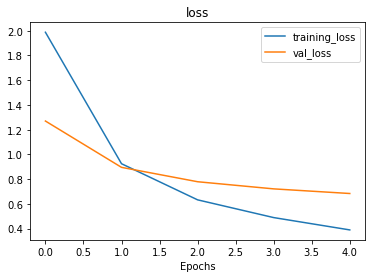

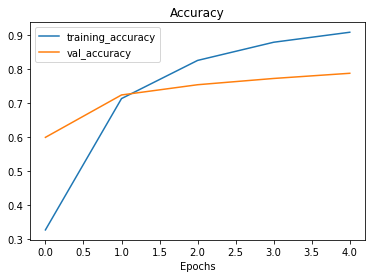

In [15]:
plot_loss_curves(resnet_history)

In [18]:
# Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction model- details on EfficientNet: https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficienNet model

efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])
# una nota, con transfer learning con menos datos puedos obtener grandes resultados
#EPOCHS = 5
# Fit EfficientNet model to 10% of training data
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              # callbacks argumento recibe una lista
                                              callbacks=[create_tensorboard_callback(dir_name="Tensorflow_hub",
                                                                                     experiment_name="efficientnetb0")])

Saving TensorBoard log files to: Tensorflow_hub/efficientnetb0/210514-075449
Epoch 1/5
24/24 [==============================] - 122s 5s/step - loss: 2.2657 - accuracy: 0.1779 - val_loss: 1.5068 - val_accuracy: 0.6092
Epoch 2/5
24/24 [==============================] - 116s 5s/step - loss: 1.3103 - accuracy: 0.6991 - val_loss: 1.0333 - val_accuracy: 0.7596
Epoch 3/5
24/24 [==============================] - 113s 5s/step - loss: 0.8886 - accuracy: 0.8143 - val_loss: 0.8184 - val_accuracy: 0.8040
Epoch 4/5
24/24 [==============================] - 103s 4s/step - loss: 0.6962 - accuracy: 0.8362 - val_loss: 0.7175 - val_accuracy: 0.8212
Epoch 5/5
24/24 [==============================] - 104s 4s/step - loss: 0.5821 - accuracy: 0.8729 - val_loss: 0.6457 - val_accuracy: 0.8364


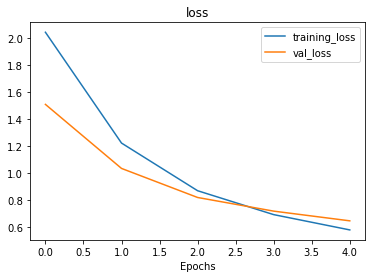

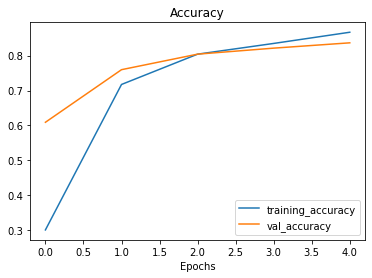

In [19]:
plot_loss_curves(efficientnet_history)

In [20]:
efficientnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1280)              3413024   
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 3,425,834
Trainable params: 12,810
Non-trainable params: 3,413,024
_________________________________________________________________


In [21]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [25]:
# How many layers does our efficientnetb0 feature extractor have?
# weights es la forma formal de decir patrones
len(efficientnet_model.layers[0].weights)

245

## Different types of transfer learning
* **"As is" transfer learning** -using an existing model with no changes what so ever(e.g using ImageNet model on 1000 ImageNet classes, none or your own)
* **"Feature extraction"** transfer learing- use the prelearned patterns of an existing model(e.g EfficientNetB0 trainet on ImageNet) and adjust the output layer for your own problem(e.g 1000 classes--> 10 classes of food)

* **"Fine-tunning"** transfer learning - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers).



## Comparing our models result using Tensorboard

> **Note**: When you upload things to TensorBoard.dev, you experiments are publics. So if you're running private experiments(things you don't want others to see) do not upload them to TensorBoard.dev.

In [27]:
!tensorboard dev upload --logdir ./Tensorflow_hub/ \
 --name "EfficientNetB0 vs ResNet50V2" \
 --description "Comparing two different TF Hub feature extraction model architectures using 10% of the training data" \
 --one_shot

^C


In [28]:
%load_ext tensorboard

In [31]:
%tensorboard

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2021-05-14 12:00:51.404514: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2021-05-14 12:00:51.404643: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Error: A logdir or db must be specified. For example `tensorboard --logdir mylogdir` or `tensorboard --db sqlite:~/.tensorboard.db`. Run `tensorboard --helpfull` for details and examples.

In [32]:
%tensorboard --logdir Tensorflow_hub/

Reusing TensorBoard on port 6006 (pid 13660), started 0:08:06 ago. (Use '!kill 13660' to kill it.)